In [ ]:
import pandas as pd
import os, bz2, json, time
from datetime import timedelta
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import re
import ast
from PIL import Image
import requests
import seaborn as sns
import nltk
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.functional as F

In [89]:
# data_en = pd.read_csv('Data3_en.csv')
# data_ru = pd.read_csv('Data3_ru.csv')
data = data_ru

In [90]:
replacer = dict()

with open('category-codes.txt') as f:
    categories = f.read().splitlines()
    for cat in categories:
        replacer[int(cat.split(' - ')[0])] = cat.split(' - ')[1]

In [91]:
text_columns = ['title', 'description', 'tags']
categorical_columns = ['categoryId', 'published_weekday', 'published_category', 'caps', 'link', 'duration_category']
TARGET_COLUMN = "view_count"

data['categoryId'] = data['categoryId'].replace(replacer)
data['duration_category'] = data['duration_category'].fillna('Medium')
data[categorical_columns[:-1]] = data[categorical_columns[:-1]].fillna('NaN')
data['title'] = data['title'].fillna('NaN')
data['description'] = data['description'].str.replace(r'http\S+', '').fillna('NaN')
data['tags'] = data['tags'].str.replace('|', ', ').replace('[None]', 'NaN')

data.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,Day10
23753,Jsn5V9o7AlE,Doston Ergashev - Dada | Достон Эргашев - Дада...,2021-11-24T12:00:20Z,UCXhlq_EYf205l29vpY254qw,RizaNovaUZ,Music,2021-11-26,"uzbek, узбек, klip, клип, yangi, янги, uzbek k...",2,4872,...,58873,335642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39174,XY9hFMK0n60,Erdoğan dünya liderlerine seslendi,2021-05-16T16:45:48Z,UC7DDcxd92wR0LzlMKIcHDAA,Show Ana Haber,News & Politics,2021-05-17,"showtv, güncel, gündem, showhaber, show haber,...",1,2230,...,81853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72344,zht1CEaYXKE,Nilufar Usmonova - Bojxonachilar | Нилуфар Усм...,2022-01-28T10:34:52Z,UCDPnSqLmYqHadD6VkrRiarg,RizaNovaUZ,Music,2022-01-29,"uzbek, узбек, klip, клип, yangi, янги, music, ...",1,4524,...,223233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
tok_mwe = nltk.tokenize.ToktokTokenizer()
data["description"] = data["description"].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data["title"] = data["title"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
data["tags"] = data["tags"].apply(lambda x: ' '.join(''.join(str(x).lower().split(' ')).split(',')))

In [93]:
token_counts = Counter()

for row in data.iterrows():
    token_counts.update([*row[1]['description'].split(), *row[1]['title'].split(), *row[1]['tags'].split()])

In [94]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 715794
(':', 458538)
(',', 405677)
('-', 329752)
('.', 326291)
('в', 210637)
...
('другаяжизньаннысмотретьонлайн', 1)
('другаяжизньанны2019', 1)
('другаяжизньаннысериал', 1)


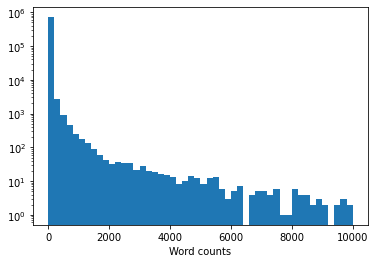

In [95]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [96]:
min_count = 5
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
print("Vocabulary size:", len(tokens))

Vocabulary size: 128605


In [97]:
token_to_id = dict(zip(tokens, [i for i in range(len(tokens))]))

In [98]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """
    Convert a list of tokens into a matrix with padding
    """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [99]:
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [100]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  58127
Validation size =  14532


In [101]:
DEVICE = torch.device('cuda')

In [102]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["description", "title", 'tags']:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.int64, device=device)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=DEVICE):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["title"] = as_matrix(data["title"].values, max_len)
    batch["description"] = as_matrix(data["description"].values, max_len)
    batch["tags"] = as_matrix(data["tags"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["description"] = apply_word_dropout(batch["description"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [103]:
class ViewsPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=n_tokens,
                                      embedding_dim=hid_size,
                                      padding_idx=0,
                                      max_norm=5.0).to(DEVICE)
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, hid_size)) for fs in [1, 2, 3, 4]]).to(DEVICE)

        self.lstm = nn.LSTM(64, hidden_size=hid_size, batch_first=True, bidirectional=True).to(DEVICE)
        self.fc = nn.Linear(hid_size * 2, 100).to(DEVICE)

        self.hidden = nn.Linear(200, 100).to(DEVICE)
                
        self.max_pool = nn.AdaptiveMaxPool1d(2).to(DEVICE)
        self.avg_pool = nn.AdaptiveAvgPool1d(2).to(DEVICE)
        
        self.categories1 = nn.Linear(n_cat_features, 300).to(DEVICE)
        self.norm_cat = nn.BatchNorm1d(300, momentum=0.1).to(DEVICE)
        self.categories2 = nn.Linear(300, 100).to(DEVICE)
        
        self.relu = nn.ReLU().to(DEVICE)
        self.dropout = nn.Dropout(0.5).to(DEVICE)
        
        self.fc1 = nn.Linear(100 * 49, hid_size, bias=True).to(DEVICE)
        self.fc2 = nn.Linear(hid_size, 1, bias=True).to(DEVICE)
        
        
    def forward(self, batch):
        # emb
        x_embed_title = self.embedding(batch['title']).unsqueeze(1)
        x_embed_description = self.embedding(batch['description']).unsqueeze(1)
        x_embed_tags = self.embedding(batch['tags']).unsqueeze(1)
            
        # # conv
        convolution_title = [conv(x_embed_title) for conv in self.convs]
        convolution_description = [conv(x_embed_description) for conv in self.convs]
        convolution_tags = [conv(x_embed_tags) for conv in self.convs]
       
        # # pooling
        max_title = torch.cat([self.max_pool(conv_title.squeeze().unsqueeze(2 if batch['title'].shape[0] != 1 else 0))
                     if len(conv_title.squeeze().shape) < 3 else self.max_pool(conv_title.squeeze())
                     for conv_title in convolution_title], dim=2)
        
        avg_title = torch.cat([self.avg_pool(conv_title.squeeze().unsqueeze(2 if batch['title'].shape[0] != 1 else 0))
                     if len(conv_title.squeeze().shape) < 3 else self.avg_pool(conv_title.squeeze())
                     for conv_title in convolution_title], dim=2)
        
        title = torch.cat([max_title, avg_title], dim=-1)

        # h0 = torch.randn(2, batch['title'].shape[0], 64, device=DEVICE)
        # c0 = torch.randn(2, batch['title'].shape[0], 64, device=DEVICE)
        # recurrent_title, (_,_) = self.lstm(x_embed_title.squeeze(1), (h0, c0))
        # title = self.max_pool(self.fc(recurrent_title).permute(0, 2, 1)) 

        # title = torch.cat([title1, title2], dim=2)
        
        max_description = torch.cat([self.max_pool(conv_description.squeeze().unsqueeze(2 if batch['description'].shape[0] != 1 else 0)) 
                     if len(conv_description.squeeze().shape) < 3 else self.max_pool(conv_description.squeeze())
                     for conv_description in convolution_description], dim=2)
        
        avg_description = torch.cat([self.avg_pool(conv_description.squeeze().unsqueeze(2 if batch['description'].shape[0] != 1 else 0)) 
                     if len(conv_description.squeeze().shape) < 3 else self.avg_pool(conv_description.squeeze())
                     for conv_description in convolution_description], dim=2)
        
        description = torch.cat([max_description, avg_description], dim=-1) 

        # h0 = torch.randn(2, batch['description'].shape[0], 64, device=DEVICE)
        # c0 = torch.randn(2, batch['description'].shape[0], 64, device=DEVICE)
        # recurrent_description, (_,_) = self.lstm(x_embed_description.squeeze(1), (h0, c0))
        # description = self.max_pool(self.fc(recurrent_description).permute(0, 2, 1)) 

        # description = torch.cat([description1, description2], dim=2)
        
        max_tags = torch.cat([self.max_pool(conv_tags.squeeze().unsqueeze(2 if batch['tags'].shape[0] != 1 else 0)) 
                     if len(conv_tags.squeeze().shape) < 3 else self.max_pool(conv_tags.squeeze())
                     for conv_tags in convolution_tags], dim=2)
        
        avg_tags = torch.cat([self.avg_pool(conv_tags.squeeze().unsqueeze(2 if batch['tags'].shape[0] != 1 else 0)) 
                     if len(conv_tags.squeeze().shape) < 3 else self.avg_pool(conv_tags.squeeze())
                     for conv_tags in convolution_tags], dim=2)
        
        tags = torch.cat([max_tags, avg_tags], dim=-1)  

        # h0 = torch.randn(2, batch['tags'].shape[0], 64, device=DEVICE)
        # c0 = torch.randn(2, batch['tags'].shape[0], 64, device=DEVICE)
        # recurrent_tags, (_,_) = self.lstm(x_embed_tags.squeeze(1), (h0, c0))
        # tags = self.max_pool(self.fc(recurrent_tags).permute(0, 2, 1)) 

        # tags = torch.cat([tags1, tags2], dim=2)
        
        # categories
        categories = self.categories2(self.norm_cat(self.categories1(batch['Categorical']))).unsqueeze(1).permute(0, 2, 1)
        
        #concat
        cat = torch.cat((title, description, tags, categories), dim=2)
        
        out = cat.view(cat.shape[0], -1)        
        out = self.fc1(self.relu(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out.reshape(-1)

In [104]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=DEVICE, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [105]:
BATCH_SIZE = 32
EPOCHS = 100

In [106]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    valid_losses = []
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
            loss = criterion(batch_pred, batch[TARGET_COLUMN])
            valid_losses.append(loss.item())
    valid_loss = np.average(valid_losses)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae, valid_loss

In [107]:
model = ViewsPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)


for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN].float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    mse, mae, valid_loss = print_metrics(model, data_val)

epoch: 0


1817it [01:41, 17.86it/s]                          


 results:
Mean square error: 0.74541
Mean absolute error: 0.64743
epoch: 1


1817it [01:40, 18.01it/s]                          


 results:
Mean square error: 0.72570
Mean absolute error: 0.63544
epoch: 2


1817it [01:41, 17.84it/s]                          


 results:
Mean square error: 0.70863
Mean absolute error: 0.62861
epoch: 3


1817it [01:41, 17.97it/s]                          


 results:
Mean square error: 0.72329
Mean absolute error: 0.61618
epoch: 4


1817it [01:41, 17.97it/s]                          


 results:
Mean square error: 0.68397
Mean absolute error: 0.61300
epoch: 5


1817it [01:41, 17.98it/s]                          


 results:
Mean square error: 0.70713
Mean absolute error: 0.60501
epoch: 6


1817it [01:41, 17.94it/s]                          


 results:
Mean square error: 0.68395
Mean absolute error: 0.59850
epoch: 7


1817it [01:40, 17.99it/s]                          


 results:
Mean square error: 0.67603
Mean absolute error: 0.59653
epoch: 8


1817it [01:40, 18.02it/s]                          


 results:
Mean square error: 0.73333
Mean absolute error: 0.60488
epoch: 9


1817it [01:41, 17.97it/s]                          


 results:
Mean square error: 0.64826
Mean absolute error: 0.59031
epoch: 10


1817it [01:41, 17.97it/s]                          


 results:
Mean square error: 0.66120
Mean absolute error: 0.58500
epoch: 11


1817it [01:40, 17.99it/s]


 results:
Mean square error: 0.68084
Mean absolute error: 0.58701
epoch: 12


1817it [01:40, 18.04it/s]


 results:
Mean square error: 0.65028
Mean absolute error: 0.60857
epoch: 13


1817it [01:41, 17.98it/s]                          


 results:
Mean square error: 0.63949
Mean absolute error: 0.59801
epoch: 14


 27%|██▋       | 498/1816 [00:27<01:13, 17.84it/s]


KeyboardInterrupt: ignored

In [108]:
torch.save(model.state_dict(), 'Data3_ru.pt')

In [109]:
preds = []
model.eval()
with torch.no_grad():
    for batch in iterate_minibatches(data_val, batch_size=BATCH_SIZE, shuffle=False):
        preds.extend(model(batch).detach().cpu().numpy().tolist())

In [110]:
from math import ceil, floor

preds_round = []
preds_ceil = []
preds_floor = []
for val in preds:
    preds_round.append(round(val))
    preds_ceil.append(ceil(val))
    preds_floor.append(floor(val))

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print('Float', mean_squared_error(preds, data_val['view_count'], squared=False))
print('Round', mean_squared_error(preds_round, data_val['view_count'], squared=False))
print('Ceil', mean_squared_error(preds_ceil, data_val['view_count'], squared=False))
print('Floor', mean_squared_error(preds_floor, data_val['view_count'], squared=False))

Float 0.8020204124283444
Round 0.8631999945918464
Ceil 0.9364988001874568
Floor 1.0147209883918642


In [122]:
from sklearn.preprocessing import StandardScaler


dayss = [f'Day{i}' for i in range(1, 11)]
X = pd.DataFrame(columns=['video_id', 'pred', *dayss, 'view_count'])
X['pred'] = preds
X['video_id'] = data_val['video_id']
for i in range(1, 11):
    X[f'Day{i}'] = data_val[f'Day{i}'].fillna(data_val[f'Day{i}'].mean())
X['view_count'] = data_val['view_count']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['pred', *dayss]].fillna(0))

y = X['view_count']

In [114]:
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor


def get_models(X_valid, y_valid):
    models = []
    max_depth = [3, 5, 7]
    max_features = [int(np.sqrt(X_train.shape[1])), X_train.shape[1] // 2, X_train.shape[1] - 1]
    alpha = np.logspace(-3, 0, 8, dtype='float')
    n_estimators = [25, 50, 100]

    print('Searching DecisionTreeRegressor...')
    searcher = GridSearchCV(DecisionTreeRegressor(random_state=21), 
                            [{"max_depth": max_depth, "max_features": max_features}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid, y_valid)
    models.append(DecisionTreeRegressor(random_state=21, max_depth=searcher.best_params_["max_depth"], 
                                        max_features=searcher.best_params_["max_features"]))
    print('Finished!\n')

    print('Searching GradientBoostingRegressor...')
    searcher = GridSearchCV(GradientBoostingRegressor(max_features='sqrt', loss='huber', random_state=21), 
                            [{"n_estimators": n_estimators, "max_depth": max_depth, 
                              "alpha": np.logspace(-4, -0.01, 8, dtype='float')}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid, y_valid)
    models.append(GradientBoostingRegressor(warm_start=False, 
                                      alpha=searcher.best_params_["alpha"], 
                                      max_depth=searcher.best_params_["max_depth"], 
                                      n_estimators=searcher.best_params_["n_estimators"], 
                                      max_features='sqrt', random_state=21))
    print('Finished!\n')

    print('Searching BaggingRegressor...')
    searcher = GridSearchCV(BaggingRegressor(random_state=21), 
                            [{"n_estimators": n_estimators, "max_features": max_features}], 
                            scoring='neg_mean_squared_error', cv=4)
    searcher.fit(X_valid, y_valid)
    models.append(BaggingRegressor(random_state=21, n_estimators=searcher.best_params_["n_estimators"], 
                                   max_features=searcher.best_params_["max_features"]))
    print('Finished!\n')

    print('Searching CatBoostRegressor...')
    models.append(CatBoostRegressor(loss_function='RMSE', random_seed=21, logging_level='Silent'))
    print('Finished!\n')

    return models

In [115]:
def testing(model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):

    start = time.time()
    model.fit(X_train, y_train)
    fin = time.time() - start

    test = y_test.copy()
    y_pred = model.predict(X_test)

    MSE = mean_squared_error(y_pred, test)
    R2 = r2_score(test, y_pred)

    return MSE, R2, fin, y_pred, test

## Russian

### Prediction, having 1 day in dataset

In [116]:
ans = pd.DataFrame(index=['DecisionTree', 'GradientBoosting', 'Bagging', 'CatBoost'], 
                   columns=['MSE', 'R2', 'Time'])

data = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [dict(), dict(), dict(), dict(), dict()]))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=6)
X_test, X_valid, y_test, y_valid = train_test_split(X_scaled, y, train_size=0.5, random_state=6)

models_set = get_models(X_valid, y_valid)

for j, model in enumerate(models_set):
    curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(model, X_train, y_train, X_test, y_test)
    try:
        data['MSE'][ans.index.to_list()[j]].append(curr_MSE)
        data['R2'][ans.index.to_list()[j]].append(curr_R2)
        data['Time'][ans.index.to_list()[j]].append(curr_fin)
        data['Pred'][ans.index.to_list()[j]].extend(curr_pred)
        data['Act'][ans.index.to_list()[j]].extend(curr_test)
    except KeyError:
        data['MSE'][ans.index.to_list()[j]] = [curr_MSE]
        data['R2'][ans.index.to_list()[j]] = [curr_R2]
        data['Time'][ans.index.to_list()[j]] = [curr_fin]
        data['Pred'][ans.index.to_list()[j]] = curr_pred.tolist()
        data['Act'][ans.index.to_list()[j]] = curr_test.tolist()

for m in ans.index.to_list():
    preds_round = []
    preds_ceil = []
    preds_floor = []
    for val in data['Pred'][m]:
        preds_round.append(round(val))
        preds_ceil.append(ceil(val))
        preds_floor.append(floor(val))

    print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
        '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
        '\n\tTime', np.sum(data['Time'][m])) 
    print('Float', mean_squared_error(data['Pred'][m], data['Act'][m], squared=False))
    print('Round', mean_squared_error(preds_round, data['Act'][m], squared=False))
    print('Ceil', mean_squared_error(preds_ceil, data['Act'][m], squared=False))
    print('Floor', mean_squared_error(preds_floor, data['Act'][m], squared=False))

Searching DecisionTreeRegressor...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

DecisionTree 
	RMSE 0.7428692847841711 
	R2 0.2583941877697875 
	Time 0.005785465240478516
Float 0.7428692847841711
Round 0.8175914760043749
Ceil 0.9288625176302514
Floor 0.9086397549298187
GradientBoosting 
	RMSE 0.7212999487705276 
	R2 0.30083428533626666 
	Time 0.15889930725097656
Float 0.7212999487705276
Round 0.7992048071048009
Ceil 0.8964406480061816
Floor 0.9209761572924288
Bagging 
	RMSE 0.3228328729622158 
	R2 0.8599433214643017 
	Time 0.9894311428070068
Float 0.3228328729622158
Round 0.32085078203505685
Ceil 0.7626355564865936
Floor 0.6671481883377277
CatBoost 
	RMSE 0.6541151849196115 
	R2 0.4250146452720853 
	Time 1.5200932025909424
Float 0.6541151849196115
Round 0.7313136866147883
Ceil 0.8567987197952472
Floor 0.8604852713931909


### Prediction, having 10 days in dataset

In [123]:
ans = pd.DataFrame(index=['DecisionTree', 'GradientBoosting', 'Bagging', 'CatBoost'], 
                   columns=['MSE', 'R2', 'Time'])

data = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [dict(), dict(), dict(), dict(), dict()]))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=6)
X_test, X_valid, y_test, y_valid = train_test_split(X_scaled, y, train_size=0.5, random_state=6)

models_set = get_models(X_valid, y_valid)

for j, model in enumerate(models_set):
    curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(model, X_train, y_train, X_test, y_test)
    try:
        data['MSE'][ans.index.to_list()[j]].append(curr_MSE)
        data['R2'][ans.index.to_list()[j]].append(curr_R2)
        data['Time'][ans.index.to_list()[j]].append(curr_fin)
        data['Pred'][ans.index.to_list()[j]].extend(curr_pred)
        data['Act'][ans.index.to_list()[j]].extend(curr_test)
    except KeyError:
        data['MSE'][ans.index.to_list()[j]] = [curr_MSE]
        data['R2'][ans.index.to_list()[j]] = [curr_R2]
        data['Time'][ans.index.to_list()[j]] = [curr_fin]
        data['Pred'][ans.index.to_list()[j]] = curr_pred.tolist()
        data['Act'][ans.index.to_list()[j]] = curr_test.tolist()

for m in ans.index.to_list():
    preds_round = []
    preds_ceil = []
    preds_floor = []
    for val in data['Pred'][m]:
        preds_round.append(round(val))
        preds_ceil.append(ceil(val))
        preds_floor.append(floor(val))

        print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
            '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
            '\n\tTime', np.sum(data['Time'][m])) 
        print('Float', mean_squared_error(data['Pred'][m], data['Act'][m], squared=False))
        print('Round', mean_squared_error(preds_round, data['Act'][m], squared=False))
        print('Ceil', mean_squared_error(preds_ceil, data['Act'][m], squared=False))
        print('Floor', mean_squared_error(preds_floor, data['Act'][m], squared=False))

Searching DecisionTreeRegressor...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

DecisionTree 
	RMSE 0.6582898653648368 
	R2 0.41765190549648534 
	Time 0.010411500930786133
Float 0.6582898653648368
Round 0.715138494514427
Ceil 0.9511173836370815
Floor 0.7633570661621435
GradientBoosting 
	RMSE 0.6214804895171349 
	R2 0.48095702310887045 
	Time 0.18789410591125488
Float 0.6214804895171349
Round 0.680930533470233
Ceil 0.9223201037577794
Floor 0.7596520854602608
Bagging 
	RMSE 0.26964223565004214 
	R2 0.9022933418689628 
	Time 1.6195454597473145
Float 0.26964223565004214
Round 0.25995193186696125
Ceil 0.8133722741599594
Floor 0.5815069122696145
CatBoost 
	RMSE 0.5685039807069739 
	R2 0.5656744875509758 
	Time 2.041318416595459
Float 0.5685039807069739
Round 0.631322956992159
Ceil 0.9017217527932333
Floor 0.7134043557770927


## English

### Prediction, having 1 day in dataset

In [88]:
ans = pd.DataFrame(index=['DecisionTree', 'GradientBoosting', 'Bagging', 'CatBoost'], 
                   columns=['MSE', 'R2', 'Time'])

data = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [dict(), dict(), dict(), dict(), dict()]))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=6)
X_test, X_valid, y_test, y_valid = train_test_split(X_scaled, y, train_size=0.5, random_state=6)

models_set = get_models(X_valid, y_valid)

for j, model in enumerate(models_set):
    curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(model, X_train, y_train, X_test, y_test)
    try:
        data['MSE'][ans.index.to_list()[j]].append(curr_MSE)
        data['R2'][ans.index.to_list()[j]].append(curr_R2)
        data['Time'][ans.index.to_list()[j]].append(curr_fin)
        data['Pred'][ans.index.to_list()[j]].extend(curr_pred)
        data['Act'][ans.index.to_list()[j]].extend(curr_test)
    except KeyError:
        data['MSE'][ans.index.to_list()[j]] = [curr_MSE]
        data['R2'][ans.index.to_list()[j]] = [curr_R2]
        data['Time'][ans.index.to_list()[j]] = [curr_fin]
        data['Pred'][ans.index.to_list()[j]] = curr_pred.tolist()
        data['Act'][ans.index.to_list()[j]] = curr_test.tolist()

for m in ans.index.to_list():
    preds_round = []
    preds_ceil = []
    preds_floor = []
    for val in data['Pred'][m]:
        preds_round.append(round(val))
        preds_ceil.append(ceil(val))
        preds_floor.append(floor(val))

        print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
            '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
            '\n\tTime', np.sum(data['Time'][m])) 
        print('Float', mean_squared_error(data['Pred'][m], data['Act'][m], squared=False))
        print('Round', mean_squared_error(preds_round, data['Act'][m], squared=False))
        print('Ceil', mean_squared_error(preds_ceil, data['Act'][m], squared=False))
        print('Floor', mean_squared_error(preds_floor, data['Act'][m], squared=False))

Searching DecisionTreeRegressor...
Finished!

Searching GradientBoostingRegressor...
Finished!

Searching BaggingRegressor...
Finished!

Searching CatBoostRegressor...
Finished!

DecisionTree 
	RMSE 1.6635274437245273 
	R2 0.30725158747343717 
	Time 0.005626201629638672
Float 1.6635274437245273
Round 1.7084998624017407
Ceil 1.7254241716826848
Floor 1.7621172715144224
GradientBoosting 
	RMSE 1.551324902468991 
	R2 0.39754983541857436 
	Time 0.15655255317687988
Float 1.551324902468991
Round 1.580255018483505
Ceil 1.6522990663092454
Floor 1.6550869032068396
Bagging 
	RMSE 0.7237596679832068 
	R2 0.8688693072651279 
	Time 0.27385568618774414
Float 0.7237596679832068
Round 0.7736221291165625
Ceil 0.927446207759367
Floor 0.9145527964785853
CatBoost 
	RMSE 1.4319882454734507 
	R2 0.4866725300908279 
	Time 1.5127933025360107
Float 1.4319882454734507
Round 1.4598089568693642
Ceil 1.5414094202509026
Floor 1.5444878960789545


### Prediction, having 10 days in dataset

In [84]:
ans = pd.DataFrame(index=['DecisionTree', 'GradientBoosting', 'Bagging', 'CatBoost'], 
                   columns=['MSE', 'R2', 'Time'])

data = dict(zip(['MSE', 'R2', 'Time', 'Pred', 'Act'] , [dict(), dict(), dict(), dict(), dict()]))


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=6)
X_test, X_valid, y_test, y_valid = train_test_split(X_scaled, y, train_size=0.5, random_state=6)

models_set = get_models(X_valid, y_valid)

for j, model in enumerate(models_set):
    curr_MSE, curr_R2, curr_fin, curr_pred, curr_test = testing(model, X_train, y_train, X_test, y_test)
    try:
        data['MSE'][ans.index.to_list()[j]].append(curr_MSE)
        data['R2'][ans.index.to_list()[j]].append(curr_R2)
        data['Time'][ans.index.to_list()[j]].append(curr_fin)
        data['Pred'][ans.index.to_list()[j]].extend(curr_pred)
        data['Act'][ans.index.to_list()[j]].extend(curr_test)
    except KeyError:
        data['MSE'][ans.index.to_list()[j]] = [curr_MSE]
        data['R2'][ans.index.to_list()[j]] = [curr_R2]
        data['Time'][ans.index.to_list()[j]] = [curr_fin]
        data['Pred'][ans.index.to_list()[j]] = curr_pred.tolist()
        data['Act'][ans.index.to_list()[j]] = curr_test.tolist()

for m in ans.index.to_list():
    preds_round = []
    preds_ceil = []
    preds_floor = []
    for val in data['Pred'][m]:
        preds_round.append(round(val))
        preds_ceil.append(ceil(val))
        preds_floor.append(floor(val))

        print(m, '\n\tRMSE', mean_squared_error(data['Act'][m], data['Pred'][m], squared=False), 
            '\n\tR2', r2_score(data['Act'][m], data['Pred'][m]),
            '\n\tTime', np.sum(data['Time'][m])) 
        print('Float', mean_squared_error(data['Pred'][m], data['Act'][m], squared=False))
        print('Round', mean_squared_error(preds_round, data['Act'][m], squared=False))
        print('Ceil', mean_squared_error(preds_ceil, data['Act'][m], squared=False))
        print('Floor', mean_squared_error(preds_floor, data['Act'][m], squared=False))

DecisionTree 
	RMSE 1.4723014809105333 
	R2 0.4573633821653903 
	Time 0.03257489204406738
Float 1.4723014809105333
Round 1.5028611996504935
Ceil 1.5811830076964162
Floor 1.5662246051670492
GradientBoosting 
	RMSE 1.0430141344224342 
	R2 0.7276696858987795 
	Time 2.283287525177002
Float 1.0430141344224342
Round 1.0783111607907478
Ceil 1.1975223560494956
Floor 1.1984552784666154
Bagging 
	RMSE 0.5383434823098683 
	R2 0.9274504842079773 
	Time 6.2538299560546875
Float 0.5383434823098683
Round 0.5777131163622546
Ceil 0.8170952168883752
Floor 0.8059051407186989
CatBoost 
	RMSE 1.0914759477975216 
	R2 0.7017750742949098 
	Time 3.745413303375244
Float 1.0914759477975216
Round 1.1247302616617127
Ceil 1.2428617078835291
Floor 1.2430864974870826
